In [362]:
# MMedLLama inference
import os
import json
import datetime
import pandas as pd
from tqdm import tqdm
from openai import OpenAI   # vLLM client
import tiktoken  # For token counting

# ============================
# ==== vLLM CONFIG ===========
# ============================

# VLLM_ENDPOINT = "http://localhost:8000/v1"
# VLLM_API_KEY = "token-abc123"
# VLLM_MODEL = "Henrychur/MMed-Llama-3-8B"

# client = OpenAI(
#     base_url=VLLM_ENDPOINT,
#     api_key=VLLM_API_KEY
# )

# ============================
# ==== Load dataset ==========
# ============================
client = OpenAI(
	base_url = "https://x2wqybxvec6wno11.us-east-1.aws.endpoints.huggingface.cloud/v1/",
    # base_url = "https://x2wqybxvec6wno11.us-east-1.aws.endpoints.huggingface.cloud",
	api_key = "Place your own API key"
)

# Initialize tokenizer for Llama-3 (uses cl100k_base encoding)
# Note: For exact Llama-3 tokenization, you might want to use transformers library instead
try:
    tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")  # Close approximation for token counting
except:
    tokenizer = tiktoken.get_encoding("cl100k_base")  # Fallback encoding

MAX_TOKENS = 7900  # Maximum tokens for input text
DATA_PATH = "truth_discovery/AD_OMIM_complete_data"
DATA_NAME = "AD"
MODEL_NAME = "MMed-Llama-3-8B"      # <-- Add model name here

data = pd.read_csv(DATA_PATH)

required_cols = {"id1", "id2", "sentence"}
assert required_cols.issubset(data.columns)

grouped = data.groupby(["id1", "id2"])
print(f"Processing {len(grouped)} unique gene-disease pairs...")

# ============================
# ==== Output Folder =========
# ============================

BASE_RESULTS_DIR = "llm_results"
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)

DATESTAMP = datetime.datetime.now().strftime("%Y-%m-%d")

# ADD MODEL NAME HERE ↓↓↓
SUMMARY_CSV_PATH = os.path.join(
    BASE_RESULTS_DIR, f"{DATA_NAME}_{MODEL_NAME}_llm_results_{DATESTAMP}.csv"
)
LOG_JSONL_PATH = os.path.join(
    BASE_RESULTS_DIR, f"{DATA_NAME}_{MODEL_NAME}_raw_responses_{DATESTAMP}.jsonl"
)

# Reset old files
for f in [SUMMARY_CSV_PATH, LOG_JSONL_PATH]:
    if os.path.exists(f):
        os.remove(f)

# ============================
# ==== Prompts ===============
# ============================
SYSTEM_PROMPT = """You are a biomedical expert. Analyze the following sentences to determine whether a causal relationship exists between two entities.

Respond ONLY with one of the two relationship labels:
  - Causal
  - Not causal

Then provide a confidence score between 0 and 1.

The response MUST follow this exact format (no extra text, no explanation):

**** <relationship>: <score> ****
"""

def build_user_prompt(sentences):
    return f"""
Sentences:
{sentences}

Return only valid JSON.
"""

# ============================
# ==== vLLM Call =============
# ============================

def call_vllm(id1, id2, text):
    # try:
    resp = client.chat.completions.create(
        model="Henrychur/MMed-Llama-3-8B",
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": build_user_prompt(text)}
        ],
        max_tokens=150,
        temperature=0,
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "causal_output",
                "schema": {
                    "type": "object",
                    "properties": {
                        "relationship": {
                            "type": "string"
                        },
                        "score": {"type": "number"}
                    },
                    "required": ["relationship", "score"]
                }
            }
        }
    )

    content = resp.choices[0].message.content
    parsed = json.loads(content)

    print(resp)
    

    # Save raw log
    with open(LOG_JSONL_PATH, "a", encoding="utf-8") as f:
        f.write(json.dumps({
            "timestamp": datetime.datetime.now().isoformat(),
            "id1": str(id1),
            "id2": str(id2),
            "response": content
        }) + "\n")

    return {
        "id1": id1,
        "id2": id2,
        "relationship": parsed.get("relationship", "Unknown"),
        "score": parsed.get("score", 0.0)
    }

    # except Exception as e:
    #     print(f"Error processing {id1}-{id2}: {str(e)}")
    #     return {"id1": id1, "id2": id2, "relationship": "Error", "score": 0.0}

# ============================
# ==== Process All ===========
# ============================

def process_all():
    results = []
    for (id1, id2), group in tqdm(grouped, desc="Processing pairs"):
        sentences = "\n".join(group["sentence"].dropna().unique())
        
        # Token-based truncation
        tokens = tokenizer.encode(sentences)
        if len(tokens) > MAX_TOKENS:
            print(f"Warning: Truncating {id1}-{id2} from {len(tokens)} to {MAX_TOKENS} tokens")
            # Truncate tokens and decode back to text
            truncated_tokens = tokens[:MAX_TOKENS]
            sentences = tokenizer.decode(truncated_tokens)
        
        results.append(call_vllm(id1, id2, sentences))
    return results

# ============================
# ==== RUN ====================
# ============================

if __name__ == "__main__":
    results = process_all()
    pd.DataFrame(results).to_csv(SUMMARY_CSV_PATH, index=False)
    print("\n✅ Completed Successfully")
    print("📄 CSV:", SUMMARY_CSV_PATH)
    print("📄 Logs:", LOG_JSONL_PATH)

Processing 10 unique gene-disease pairs...


Processing pairs:   0%|          | 0/10 [00:00<?, ?it/s]

Processing pairs:  10%|█         | 1/10 [00:02<00:25,  2.86s/it]

ChatCompletion(id='chatcmpl-uiDUei', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship":"Causal","score":0.0}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355978, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=8000, total_tokens=8016, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  20%|██        | 2/10 [00:06<00:24,  3.11s/it]

ChatCompletion(id='chatcmpl-_J9_I6', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship": "Causal", "score": 0.9999999999999999}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355981, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=21, prompt_tokens=3297, total_tokens=3318, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  30%|███       | 3/10 [00:11<00:27,  3.97s/it]

ChatCompletion(id='chatcmpl-GkMWt3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship":"Causal","score":0.9999999999999999}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355986, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=21, prompt_tokens=7365, total_tokens=7386, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  40%|████      | 4/10 [00:16<00:27,  4.59s/it]

ChatCompletion(id='chatcmpl-EL29xR', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship":"Causal","score":0.5}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355991, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=7999, total_tokens=8015, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  50%|█████     | 5/10 [00:20<00:20,  4.17s/it]

ChatCompletion(id='chatcmpl-n0OshH', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship":"Causal","score":0.5}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355995, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=13, prompt_tokens=3716, total_tokens=3729, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  60%|██████    | 6/10 [00:21<00:13,  3.31s/it]

ChatCompletion(id='chatcmpl--i2jQh', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship": "Not causal", "score": 1.0}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355997, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=497, total_tokens=513, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  70%|███████   | 7/10 [00:22<00:07,  2.61s/it]

ChatCompletion(id='chatcmpl-XY5yjw', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship": "Not causal", "score": 0.0}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763355998, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=744, total_tokens=760, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  80%|████████  | 8/10 [00:27<00:06,  3.18s/it]

ChatCompletion(id='chatcmpl-J1pGSH', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship":"Not causal","score":0.0}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763356002, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=13, prompt_tokens=4322, total_tokens=4335, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs:  90%|█████████ | 9/10 [00:29<00:02,  2.94s/it]

ChatCompletion(id='chatcmpl-x-KH2P', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship": "Causal", "score": 0.9}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763356005, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=1633, total_tokens=1649, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)


Processing pairs: 100%|██████████| 10/10 [00:31<00:00,  3.14s/it]

ChatCompletion(id='chatcmpl-MuCwVo', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"relationship": "Not causal", "score": 1.0}', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None, token_ids=None)], created=1763356007, model='Henrychur/MMed-Llama-3-8B', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=16, prompt_tokens=935, total_tokens=951, completion_tokens_details=None, prompt_tokens_details=None), prompt_logprobs=None, prompt_token_ids=None, kv_transfer_params=None)

✅ Completed Successfully
📄 CSV: llm_results/AD_neg_MMed-Llama-3-8B_llm_results_2025-11-17.csv
📄 Logs: llm_results/AD_neg_MMed-Llama-3-8B_raw_responses_2025-11-17.jsonl


In [363]:
pd.read_json('llm_results/AD_neg_MMed-Llama-3-8B_raw_responses_2025-11-17.jsonl',lines=True)

,timestamp,id1,id2,response
0,2025-11-17 10:36:19.164095,102,D000544,"{""relationship"":""Causal"",""score"":0.0}"
1,2025-11-17 10:36:22.442370,3570,D000544,"{""relationship"": ""Causal"", ""score"": 0.99999999..."
2,2025-11-17 10:36:27.434789,4353,D000544,"{""relationship"":""Causal"",""score"":0.99999999999..."
3,2025-11-17 10:36:32.965972,4846,D000544,"{""relationship"":""Causal"",""score"":0.5}"
4,2025-11-17 10:36:36.388332,5328,D000544,"{""relationship"":""Causal"",""score"":0.5}"
5,2025-11-17 10:36:38.035760,9474,D000544,"{""relationship"": ""Not causal"", ""score"": 1.0}"
6,2025-11-17 10:36:39.208258,54209,D000544,"{""relationship"": ""Not causal"", ""score"": 0.0}"
7,2025-11-17 10:36:43.608918,84909,D000544,"{""relationship"":""Not causal"",""score"":0.0}"
8,2025-11-17 10:36:46.035490,100132406,D000544,"{""relationship"": ""Causal"", ""score"": 0.9}"
9,2025-11-17 10:36:47.682234,100293534,D000544,"{""relationship"": ""Not causal"", ""score"": 1.0}"


In [353]:
#GPT-4o inference

import os
import json
import datetime
import pandas as pd
from tqdm import tqdm
from openai import AzureOpenAI  # Changed to AzureOpenAI

# ==== Azure OpenAI Config ====
AZURE_OPENAI_API_KEY = "Place your own API key"
AZURE_OPENAI_ENDPOINT = "https://teccspazureopenai.openai.azure.com/"
AZURE_DEPLOYMENT = "gpt-4o"  # Azure deployment name

# ==== Initialize Azure Client (Correct for new SDK) ====
client = AzureOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,  # Use azure_endpoint instead of base_url
    api_version="2024-02-01"  # API version for Azure
)

# ============================
# ==== Load dataset ==========
# ============================
DATA_PATH = "truth_discovery/AD_OMIM_complete_data"  # Added .csv extension
DATA_NAME = "AD"
data = pd.read_csv(DATA_PATH)
required_cols = {"id1", "id2", "sentence"}
assert required_cols.issubset(data.columns)
grouped = data.groupby(["id1", "id2"])
print(f"Processing {len(grouped)} unique gene-disease pairs...")

# ============================
# ==== Output Folder =========
# ============================
BASE_RESULTS_DIR = "llm_results"
os.makedirs(BASE_RESULTS_DIR, exist_ok=True)
SUMMARY_CSV_PATH = os.path.join(BASE_RESULTS_DIR, f"{DATA_NAME}_llm_results.csv")
LOG_JSONL_PATH = os.path.join(BASE_RESULTS_DIR, f"{DATA_NAME}_raw_responses.jsonl")

# Reset old files
for f in [SUMMARY_CSV_PATH, LOG_JSONL_PATH]:
    if os.path.exists(f):
        os.remove(f)

# ============================
# ==== Prompts ===============
# ============================
SYSTEM_PROMPT = """You are a biomedical expert. Analyze the following sentences to determine whether a causal relationship exists between two entities.

Respond ONLY with one of the two relationship labels:
  - Causal
  - Not causal

Then provide a confidence score between 0 and 1.


"""

def build_user_prompt(sentences):
    return f"""
Sentences:
{sentences}
Does GeneSrc cause DiseaseTgt?
Return only valid JSON.
"""

# ============================
# ==== Azure Call ============
# ============================
def call_azure_openai(id1, id2, text):
    try:
        resp = client.chat.completions.create(
            model=AZURE_DEPLOYMENT,  # Use deployment name directly
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": build_user_prompt(text)}
            ],
            max_tokens=100,
            temperature=0,
            response_format={"type": "json_object"},
            # STRICT JSON OUTPUT
        )
        
        # Correct way to access content in new SDK
        content = resp.choices[0].message.content
        parsed = json.loads(content)
        
        # Save raw log
        with open(LOG_JSONL_PATH, "a", encoding="utf-8") as f:
            f.write(json.dumps({
                "timestamp": datetime.datetime.now().isoformat(),
                "id1": str(id1),
                "id2": str(id2),
                "response": content
            }) + "\n")
        
        return {
            "id1": id1,
            "id2": id2,
            "relationship": parsed.get("relationship", "Unknown"),
            "score": parsed.get("confidence", 0.0)
        }
    
    except Exception as e:
        print(f"Error processing {id1}-{id2}: {str(e)}")
        # Return default values on error
        return {
            "id1": id1,
            "id2": id2,
            "relationship": "Error",
            "score": 0.0
        }

# ============================
# ==== Process All ===========
# ============================
def process_all():
    results = []
    for (id1, id2), group in tqdm(grouped, desc="Processing pairs"):
        sentences = "\n".join(group["sentence"].dropna().unique())
        results.append(call_azure_openai(id1, id2, sentences))
    return results

# ============================
# ==== RUN ====================
# ============================
if __name__ == "__main__":
    results = process_all()
    pd.DataFrame(results).to_csv(SUMMARY_CSV_PATH, index=False)
    print("\n✅ Completed Successfully")
    print("📄 CSV:", SUMMARY_CSV_PATH)
    print("📄 Logs:", LOG_JSONL_PATH)

# Version: 1.99.9

Processing 10 unique gene-disease pairs...


Processing pairs: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


✅ Completed Successfully
📄 CSV: llm_results/AD_neg_llm_results.csv
📄 Logs: llm_results/AD_neg_raw_responses.jsonl


In [373]:
gene_symbols_table = [
    'APP', 'APOE', 'PSEN1', 'PSEN2', 'TREM2', 'NOS3', 'PLAU', 'ADAM10', 
    'ABCA7', 'MPO']
data1_filtered = data1[data1['Symbol'].isin(gene_symbols_table)]

In [375]:
data1

,id1,id2,relationship,score,openai_response,medllama_response,medllama_score,medllama_relationship,Symbol
0,102,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Causal"",""score"":0.0}",0.0,Causal,NaN
1,3570,D000544,Causal,0.85,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Causal"", ""score"": 0.99999999...",1.0,Causal,NaN
2,4353,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Causal"",""score"":0.99999999999...",1.0,Causal,NaN
3,4846,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Causal"",""score"":0.5}",0.5,Causal,NaN
4,5328,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Causal"",""score"":0.5}",0.5,Causal,NaN
5,9474,D000544,Not causal,0.90,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Not causal"", ""score"": 1.0}",1.0,Not causal,NaN
6,54209,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Not causal"", ""score"": 0.0}",0.0,Not causal,NaN
7,84909,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Not causal"",""score"":0.0}",0.0,Not causal,NaN
8,100132406,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,NaN
9,100293534,D000544,Not causal,0.85,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Not causal"", ""score"": 1.0}",1.0,Not causal,NaN


In [376]:
data1['vq*']=data_unique['vq*']
gene_symbols_table = [
    'APP', 'APOE', 'PSEN1', 'PSEN2', 'TREM2', 'NOS3', 'PLAU', 'ADAM10', 
    'ABCA7', 'MPO']

data1['omim'] = data1['Symbol'].isin(gene_symbols_table)

In [252]:
data1.to_csv('LLM_inference_AD_OMIM.csv', index=False)

In [259]:
df=data1
mask1 = (df['relationship'].str.lower().str.contains('not causal', na=False)) & (df['score'] > 0.5)
df.loc[mask1, 'score'] = 1 - df.loc[mask1, 'score']

mask2 = (df['medllama_relationship'].str.lower().str.contains('not causal', na=False)) & (df['medllama_score'] > 0.5)
df.loc[mask2, 'medllama_score'] = 1 - df.loc[mask2, 'medllama_score']

In [261]:
df

,id1,id2,relationship,score,openai_response,medllama_response,medllama_score,medllama_relationship,Symbol,vq*,omim
0,1000,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,CDH2,1.0,False
1,10195,D000544,Causal,0.85,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Not causal"", ""score"": 0.0}",0.0,Not causal,ALG3,1.0,False
2,102,D000544,Not causal,0.10,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,ADAM10,0.0,True
3,10347,D000544,Not causal,0.20,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.99999999...",1.0,Causal,ABCA7,0.0,True
4,103979,D000544,Not causal,0.15,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,Alph1,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...
219,93649,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Not causal"", ""score"": 0.0}",0.0,Not causal,MYOCD,0.0,False
220,945,D000544,Causal,0.85,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,CD33,0.0,False
221,9451,D000544,Not causal,0.20,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Not causal"", ""score"": 1.0}",0.0,Not causal,EIF2AK3,0.0,False
222,98256,D000544,Not causal,0.15,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,Kmo,0.0,False


In [288]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_reports(df, score_columns, threshold=0.9, ground_truth_col='omim_binary'):
    """
    Prints the full sklearn classification report for multiple models at a specific threshold.
    """
    print(f"\n{'='*60}")
    print(f"CLASSIFICATION REPORT @ THRESHOLD {threshold}")
    print(f"{'='*60}")

    valid_cols = [c for c in score_columns if c in df.columns]
    
    for col in valid_cols:
        # 1. Get Data (Drop NaNs for this specific column)
        mask = df[col].notna() & df[ground_truth_col].notna()
        if mask.sum() == 0:
            print(f"Skipping {col} (No valid data)")
            continue
            
        y_true = df.loc[mask, ground_truth_col]
        y_scores = df.loc[mask, col]
        
        # 2. Check Scale Warning
        # If scores are 0-100 and threshold is 0.9, the report will be meaningless (everything becomes 1)
        if y_scores.max() > 1.0 and threshold < 1.0:
            print(f"\n[WARNING] '{col}' max value is {y_scores.max()}.")
            print(f"           Threshold {threshold} might be too low. Did you mean 90?")

        # 3. Apply Threshold
        y_pred = (y_scores >= threshold).astype(int)
        
        # 4. Generate Report
        # zero_division=0 prevents errors if a model predicts only one class
        report = classification_report(y_true, y_pred, 
                                     target_names=['Not OMIM (0)', 'OMIM (1)'],
                                     zero_division=0)
        display_names = {
        'score': 'GPT-4o',
        'medllama_score': 'MedLLama',
        'vq*': 'CWTD'
        }
        print(f"\n--- Model: {display_names[col]} ---")
        print(report)

# ==========================================
# EXECUTION
# ==========================================
# Assuming 'df_prepared' is your dataframe
cols_to_test = ['score', 'medllama_score', 'vq*']
df_prepared = prepare_data(df)
df_prepared = df_prepared.drop_duplicates(subset='id1', keep='first')
generate_classification_reports(df_prepared, cols_to_test, threshold=0.9)


CLASSIFICATION REPORT @ THRESHOLD 0.9

--- Model: GPT-4o ---
              precision    recall  f1-score   support

Not OMIM (0)       0.96      0.45      0.61       211
    OMIM (1)       0.04      0.56      0.08         9

    accuracy                           0.45       220
   macro avg       0.50      0.50      0.34       220
weighted avg       0.92      0.45      0.59       220


--- Model: MedLLama ---
              precision    recall  f1-score   support

Not OMIM (0)       0.93      0.30      0.45       211
    OMIM (1)       0.03      0.44      0.05         9

    accuracy                           0.30       220
   macro avg       0.48      0.37      0.25       220
weighted avg       0.89      0.30      0.44       220


--- Model: CWTD ---
              precision    recall  f1-score   support

Not OMIM (0)       0.98      0.78      0.87       211
    OMIM (1)       0.11      0.67      0.19         9

    accuracy                           0.77       220
   macro avg       0

In [290]:
df_prepared['omim'].value_counts()

omim
False    211
True       9
Name: count, dtype: int64

In [397]:
def plot_pr_curves(df, score_columns, ground_truth_col='omim_binary',
                   manual_thresholds=None):
    """
    Plots Precision–Recall curves for multiple models and shows their AUCs.
    """
    plt.figure(figsize=(5, 4))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, linestyle='--', alpha=0.6)
    
    display_names = {
        'score': 'GPT-4o',
        'medllama_score': 'MedLLama',
        'vq*': 'CSTD'
    }

    # ============================================
    # NEW BASELINE CALCULATION
    # ============================================
    positive_rate = df[ground_truth_col].mean()  # prevalence
    plt.axhline(
        y=positive_rate,
        linestyle='--',
        color='black',
        linewidth=1.5,
        label=f'Baseline'
    )
    # ============================================

    for col in score_columns:
        if col not in df.columns:
            print(f"Column {col} not in DataFrame, skipping.")
            continue

        mask = df[col].notna() & df[ground_truth_col].notna()
        if mask.sum() == 0:
            print(f"Skipping {col} — no valid data.")
            continue

        y_true = df.loc[mask, ground_truth_col].astype(int).values
        y_scores = df.loc[mask, col].astype(float).values

        if manual_thresholds is None:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
        else:
            precision, recall, _ = pr_at_thresholds_like_sklearn(
                y_true, y_scores, manual_thresholds, add_anchor=True
            )

        pr_auc = auc(recall, precision)
        label_name = display_names.get(col, col)

        plt.plot(
            recall,
            precision,
            linewidth=2,
            label=f"{label_name} (AUC={pr_auc:.3f})"
        )

        if manual_thresholds is not None:
            plt.scatter(recall, precision, s=2)

    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('PR_curve_AD')
    
    plt.show()


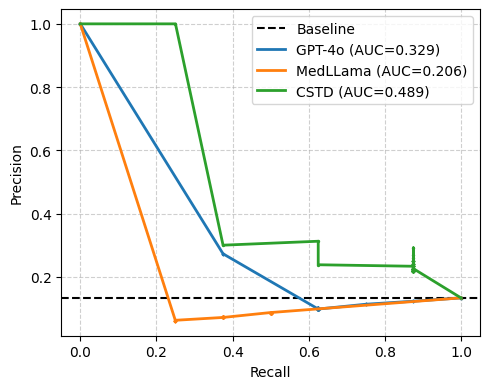

In [398]:
df_prepared = df_prepared.drop_duplicates(subset='id1', keep='first')

cols_to_test = ['score', 'medllama_score', 'vq*']

manual_thresholds = np.linspace(0,1,100)

df_filtered = df_prepared[df_prepared['total'] >= 2].copy()

plot_pr_curves(
    df_filtered,
    cols_to_test,
    ground_truth_col='omim_binary',
    manual_thresholds=manual_thresholds
)


In [337]:
df_prepared.to_csv('LLM_inference_AD_OMIM.csv', index=False)

In [386]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def recall_at_k_curve(df, score_cols, ground_truth_col='omim_binary',
                      k_values=None, display_names=None,
                      min_total_count=0):
    """
    Compute and plot Recall@K curves for multiple model score columns.
    Only uses rows where total_count >= min_total_count.
    """

    # ------------------------------
    # NEW: filter by total_count >= min_total_count
    # ------------------------------
    if 'total' not in df.columns:
        raise ValueError("df must contain 'total_count' column")

    df = df[df['total'] >= min_total_count].copy()
    # ------------------------------

    plt.figure(figsize=(6,4))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel("K")
    plt.ylabel("Recall@K")

    if k_values is None:
        k_values = np.arange(1, min(200, len(df)) + 1)

    if display_names is None:
        display_names = {col: col for col in score_cols}

    total_positives = df[ground_truth_col].sum()

    for col in score_cols:
        if col not in df.columns:
            print(f"Column {col} missing, skipping.")
            continue

        mask = df[col].notna() & df[ground_truth_col].notna()
        df_valid = df.loc[mask].copy()

        df_valid = df_valid.sort_values(col, ascending=False)

        recalls = []
        for k in k_values:
            topk = df_valid.head(k)
            tp_at_k = topk[ground_truth_col].sum()
            recall = tp_at_k / total_positives if total_positives > 0 else 0
            recalls.append(recall)

        plt.plot(k_values, recalls, linewidth=2,
                 label=display_names.get(col, col))

    plt.legend()
    plt.tight_layout()
    plt.savefig("Recall_curve_AD")
    plt.show()


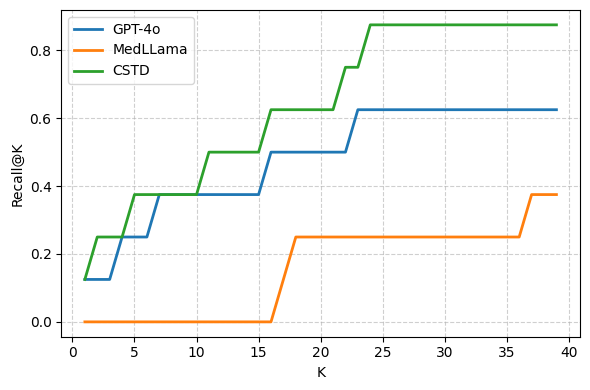

In [396]:
score_columns = ['score', 'medllama_score', 'vq*']

display_names = {
    'score': 'GPT-4o',
    'medllama_score': 'MedLLama',
    'vq*': 'CSTD'
}

k_values = np.arange(1, 40)

recall_at_k_curve(
    df_prepared,
    score_columns,
    ground_truth_col='omim_binary',
    k_values=k_values,
    display_names=display_names,
    min_total_count=2      # <-- FILTER APPLIED HERE
)


In [342]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

def generate_classification_reports(df, score_columns, threshold=0.9,
                                    ground_truth_col='omim_binary',
                                    min_total_count=0):
    """
    Prints the full sklearn classification report for multiple models at a specific threshold.
    Evaluates ONLY rows where total_count >= min_total_count.
    """

    # -----------------------------------------
    # NEW: Filter by total_count >= min_total_count
    # -----------------------------------------
    if 'total' not in df.columns:
        raise ValueError("df must contain 'total_count' column.")

    df = df[df['total'] >= min_total_count].copy()
    # -----------------------------------------

    print(f"\nUsing only id1,id2 pairs with total_count >= {min_total_count}")
    print(f"Remaining rows = {len(df)}")

    print(f"\n{'='*60}")
    print(f"CLASSIFICATION REPORT @ THRESHOLD {threshold}")
    print(f"{'='*60}")

    valid_cols = [c for c in score_columns if c in df.columns]

    for col in valid_cols:

        mask = df[col].notna() & df[ground_truth_col].notna()
        if mask.sum() == 0:
            print(f"Skipping {col} (No valid data)")
            continue

        y_true = df.loc[mask, ground_truth_col]
        y_scores = df.loc[mask, col]

        if y_scores.max() > 1.0 and threshold < 1.0:
            print(f"\n[WARNING] '{col}' max value is {y_scores.max()}.")
            print(f"           Threshold {threshold} might be too low. Did you mean 90?")

        y_pred = (y_scores >= threshold).astype(int)

        report = classification_report(
            y_true, y_pred,
            target_names=['Not OMIM (0)', 'OMIM (1)'],
            zero_division=0
        )

        display_names = {
            'score': 'GPT-4o',
            'medllama_score': 'MedLLama',
            'vq*': 'CWTD'
        }

        print(f"\n--- Model: {display_names[col]} ---")
        print(report)


In [381]:
cols_to_test = ['score', 'medllama_score', 'vq*']

# df_prepared = prepare_data(df)
# df_prepared = df_prepared.drop_duplicates(subset='id1', keep='first')

# Evaluate only pairs with >= 5 supporting sentences
generate_classification_reports(
    df_prepared,
    cols_to_test,
    threshold=0.9,
    min_total_count=2
)



Using only id1,id2 pairs with total_count >= 2
Remaining rows = 60

CLASSIFICATION REPORT @ THRESHOLD 0.9

--- Model: GPT-4o ---
              precision    recall  f1-score   support

Not OMIM (0)       0.73      0.15      0.25        52
    OMIM (1)       0.10      0.62      0.18         8

    accuracy                           0.22        60
   macro avg       0.41      0.39      0.21        60
weighted avg       0.64      0.22      0.24        60


--- Model: MedLLama ---
              precision    recall  f1-score   support

Not OMIM (0)       0.72      0.25      0.37        52
    OMIM (1)       0.07      0.38      0.12         8

    accuracy                           0.27        60
   macro avg       0.40      0.31      0.25        60
weighted avg       0.64      0.27      0.34        60


--- Model: CWTD ---
              precision    recall  f1-score   support

Not OMIM (0)       0.97      0.60      0.74        52
    OMIM (1)       0.25      0.88      0.39         8

    ac

In [347]:
gene_symbols_table = [
    'APP', 'APOE', 'PSEN1', 'PSEN2', 'TREM2', 'NOS3', 'PLAU', 'ADAM10', 
    'ABCA7', 'MPO'
]
matched_rows = df_prepared[df_prepared['Symbol'].isin(gene_symbols_table)]
matched_rows

,id1,id2,relationship,score,openai_response,medllama_response,medllama_score,medllama_relationship,Symbol,vq*,omim,omim_binary,number_of_causal,total
2,102,D000544,Not causal,0.10,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.9}",0.9,Causal,ADAM10,0.000000,True,1,0,2
3,10347,D000544,Not causal,0.20,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.99999999...",1.0,Causal,ABCA7,0.000000,True,1,0,1
125,348,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Causal"",""score"":0.0}",0.0,Causal,APOE,0.969096,True,1,26,117
126,351,D000544,Causal,0.95,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""causal"", ""score"": 1.0}",1.0,causal,APP,0.989709,True,1,73,154
144,4353,D000544,Causal,0.90,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""Causal"", ""score"": 0.99999999...",1.0,Causal,MPO,1.000000,True,1,2,2
146,4846,D000544,Not causal,0.20,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Causal"", ""score"": 0.5}",0.5,Causal,NOS3,0.984214,True,1,1,3
151,5328,D000544,Not causal,0.15,"{\n ""relationship"": ""Not causal"",\n ""confide...","{""relationship"": ""Not causal"", ""score"": 0.0}",0.0,Not causal,PLAU,1.000000,True,1,3,3
165,5663,D000544,Causal,0.95,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"":""Causal"",""score"":0.0}",0.0,Causal,PSEN1,0.993728,True,1,57,95
167,5664,D000544,Causal,0.95,"{\n ""relationship"": ""Causal"",\n ""confidence""...","{""relationship"": ""causal"", ""score"": 0.0}",0.0,causal,PSEN2,0.968435,True,1,23,40


In [350]:
df_omim_comp['pred_label'].value_counts()

pred_label
0.0    561
1.0    286
Name: count, dtype: int64